In [1]:
import os, tempfile
import logging
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC import plot_sim_results, plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.3
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:289: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:303: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:289: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:303: SyntaxWarning: assertion is always true, perhaps remove parentheses?


In [3]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

In [14]:
from experiments.ical_li import (li_act_and_tau,
                                 li_inact_1000,
                                 li_inact_kin_80,
                                 li_recov)

In [15]:
modelfile = 'models/standardised_ical.mmt'

## Plot steady-state and tau functions

In [16]:
from ionchannelABC.visualization import plot_variables

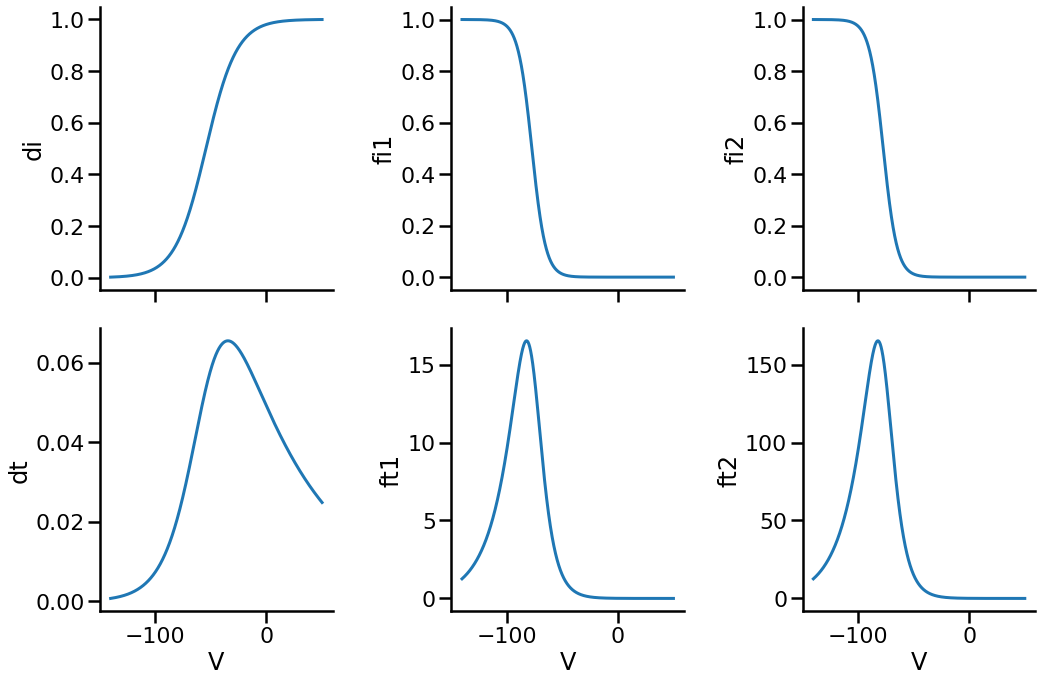

In [17]:
sns.set_context('poster')

V = np.arange(-140, 50, 0.01)

sta_vars = {'di': 'ical.d_ss',
            'fi1': 'ical.f_ss',
            'fi2': 'ical.f_ss',
            'dt':  'ical.tau_d',
            'ft1': 'ical.tau_f1',
            'ft2': 'ical.tau_f2'}

f, ax = plot_variables(V, sta_vars, 'models/standardised_ical.mmt', figshape=(3,2))

In [18]:
observations, model, summary_statistics = setup(modelfile,
                                                li_act_and_tau,
                                                li_inact_1000,
                                                li_inact_kin_80,
                                                li_recov)

In [19]:
assert len(observations)==len(summary_statistics(model({})))

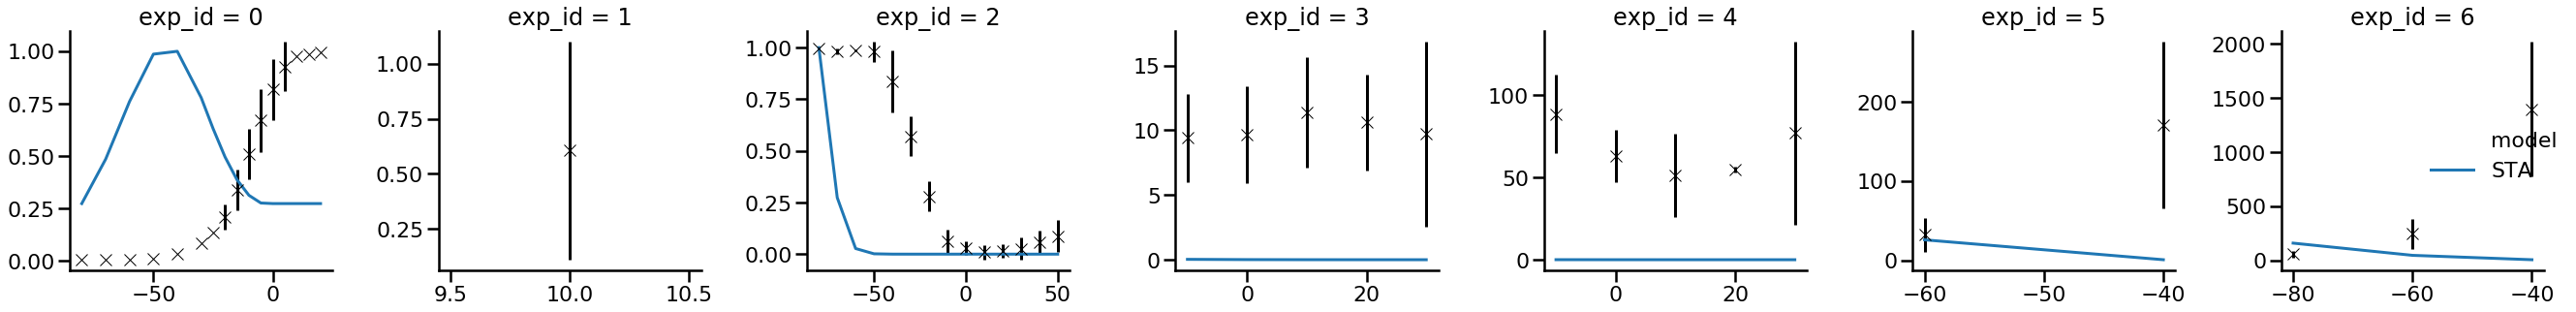

In [20]:
g = plot_sim_results(modelfile,
                     li_act_and_tau,
                     li_inact_1000,
                     li_inact_kin_80,
                     li_recov)

In [23]:
limits = {'log_ical.p_1': (-7, 3),
          'ical.p_2': (1e-7, 0.4),
          'log_ical.p_3': (-7, 3),
          'ical.p_4': (1e-7, 0.4),
          'log_ical.p_5': (-7, 3),
          'ical.p_6': (1e-7, 0.4),
          'log_ical.p_7': (-7, 3),
          'ical.p_8': (1e-7, 0.4),
          'log_ical.A': (0., 2.)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [24]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "standardised_ical.db"))

In [25]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [26]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 512 particles


In [27]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9678753977594495, '1': 0.9678753977594495, '2': 0.9678753977594495, '3': 0.9678753977594495, '4': 0.9678753977594495, '5': 0.9678753977594495, '6': 0.9678753977594495, '7': 0.8108388442136876, '8': 0.4949276062083544, '9': 0.40434403902433114, '10': 0.3182415505473346, '11': 0.32995173747223605, '12': 0.4054194221068438, '13': 0.9678753977594495, '14': 0.9678753977594495, '15': 0.9678753977594495, '16': 0.948320343641584, '17': 1.106143311725085, '18': 1.106143311725085, '19': 1.106143311725085, '20': 1.106143311725085, '21': 0.3661134182449056, '22': 0.5684392546434062, '23': 0.7593993167501771, '24': 0.9437195392623547, '25': 1.106143311725085, '26': 1.106143311725085, '27': 1.106143311725085, '28': 1.0340756653619416, '29': 0.9437195392623547, '30': 0.7095117703943247, '31': 0.5182027705336358, '32': 0.47053527060396233, '33': 0.4147752932240028, '34': 0.47137080052372676, '35': 0.24685138829306388, '36': 0.5737108704898386, '37': 0.86131728575

In [28]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [29]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-17 19:57:53.639377, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

### Database results analysis

In [19]:
store_path = '/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/nygren/ical/reported/'

In [20]:
history = History('sqlite:///'+store_path+'nygren_ical_d_reported.db')

In [24]:
history = History(db_path)

In [25]:
df, w = history.get_distribution(m=0)

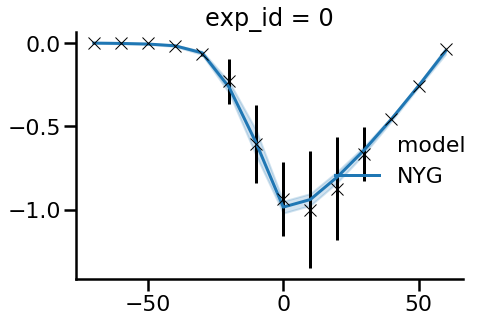

In [26]:
g = plot_sim_results(modelfile,
                     li_iv_80_norm,
                     df=df, w=w)

In [27]:
nyg_pars = df.sample(n=100, weights=w, replace=True)
nyg_pars = nyg_pars.set_index([pd.Index(range(100))])
nyg_pars = nyg_pars.to_dict(orient='records')

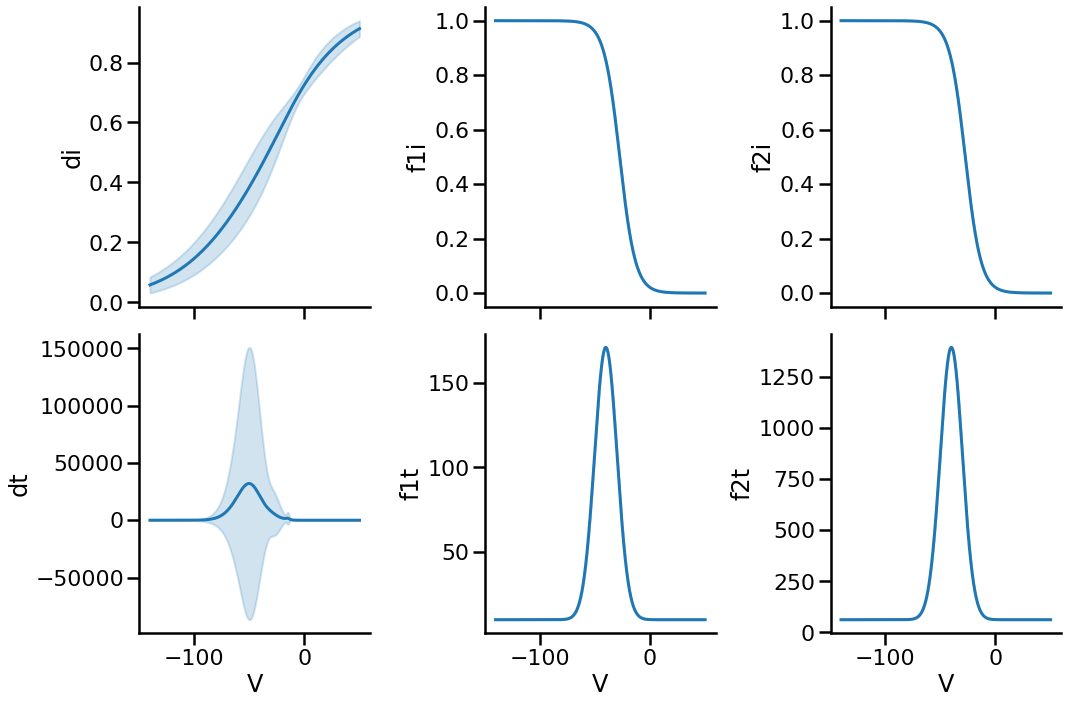

In [28]:
sns.set_context('poster')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, nyg_vars, 
                       'models/nygren_ical.mmt', 
                       [nyg_pars],
                       figshape=(3,2))

In [29]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [30]:
m,_,_ = myokit.load(modelfile)

In [31]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

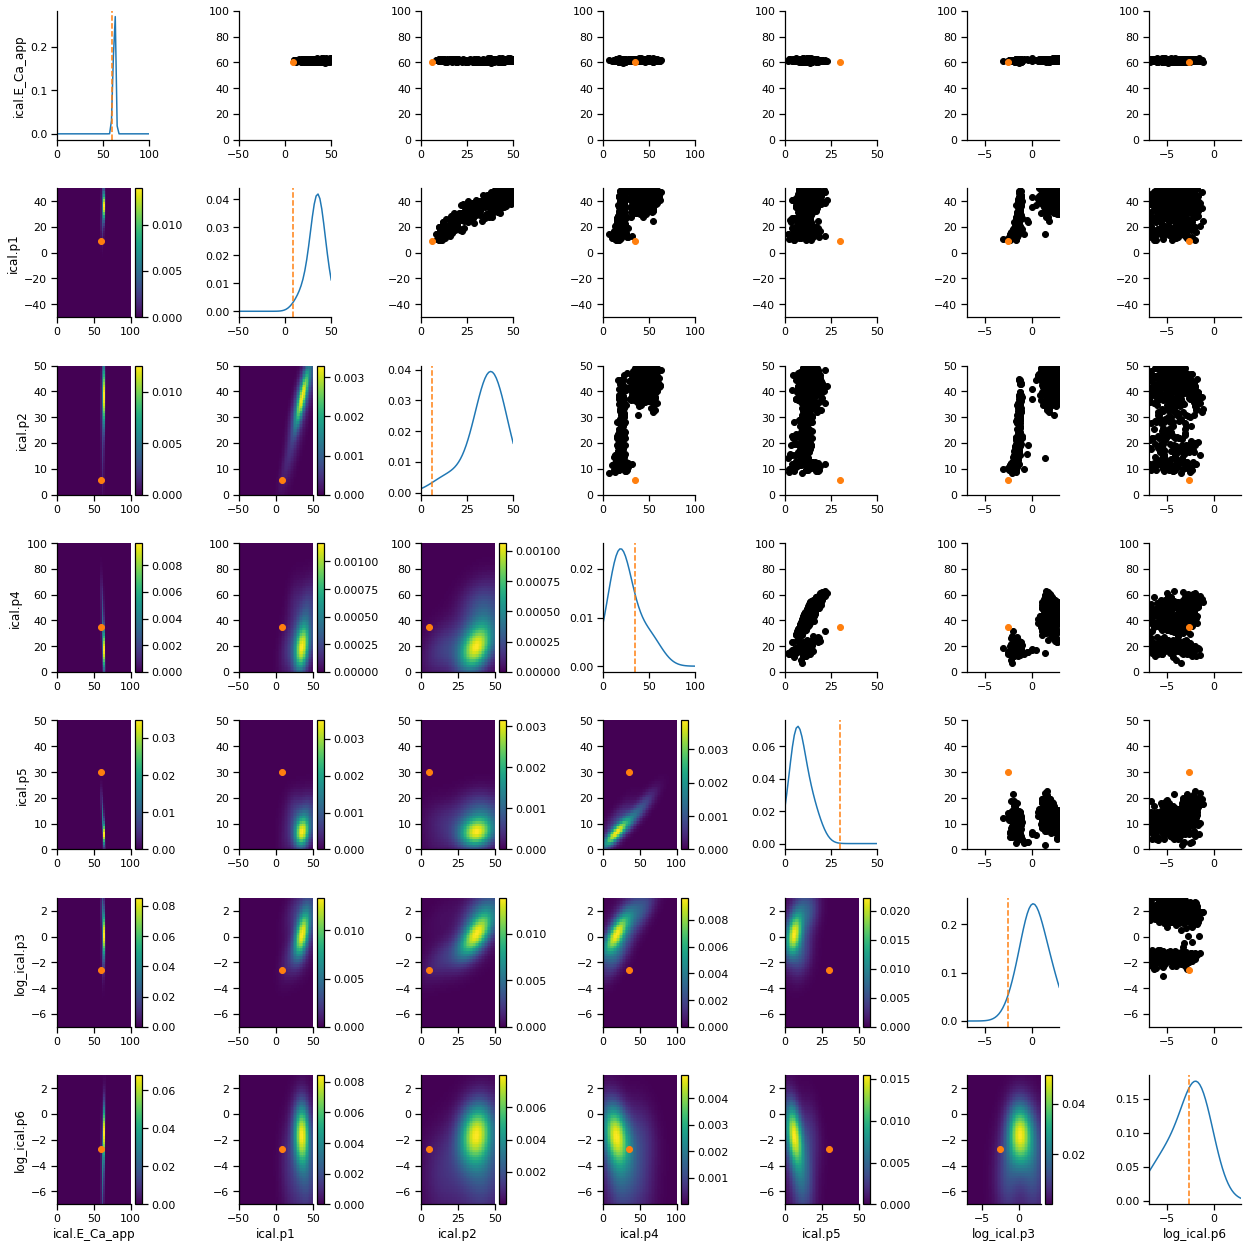

In [33]:
sns.set_context('notebook')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)

# f gate -> Inactivation

In [34]:
observations, model, summary_statistics = setup(modelfile,
                                                li_inact_1000,
                                                li_inact_kin_80,
                                                li_recov)

In [35]:
assert len(observations)==len(summary_statistics(model({})))

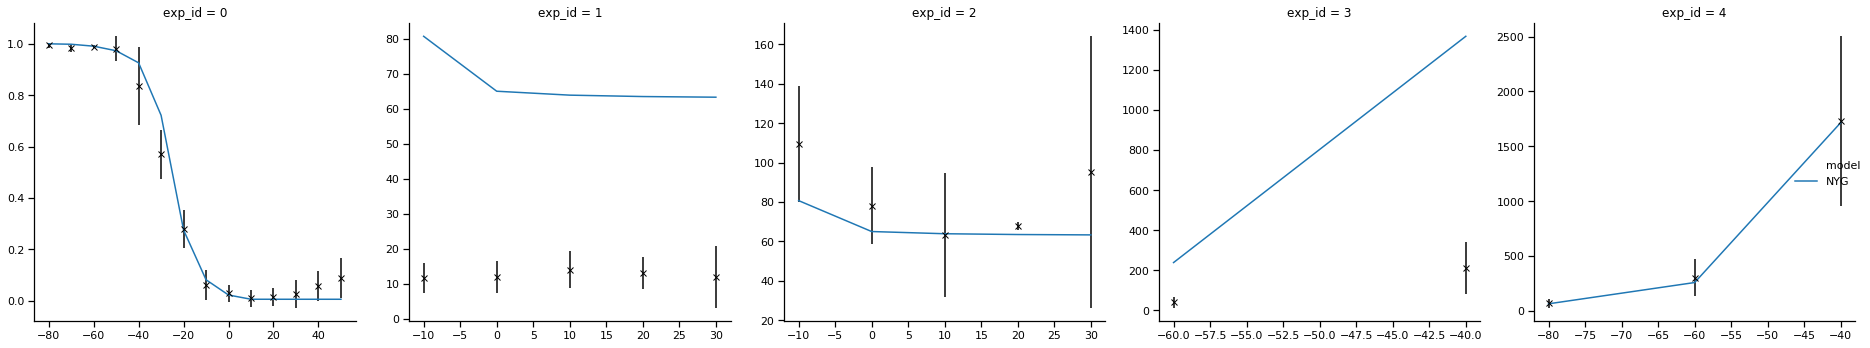

In [36]:
g = plot_sim_results(modelfile,
                     li_inact_1000,
                     li_inact_kin_80,
                     li_recov)

In [37]:
limits = {#'ical.p1': (-50, 50),
          #'ical.p2': (0, 50),
          #'log_ical.p3': (-7, 3),
          #'ical.p4': (0, 100),
          #'ical.p5': (0, 50),
          #'log_ical.p6': (-7, 3),
          'ical.E_Ca_app': (0, 100),
          'ical.q1': (0, 100),
          'ical.q2': (0, 50),
          'log_ical.q3': (-7, 3),
          'ical.q4': (0, 100),
          'ical.q5': (0, 50),
          'log_ical.q6': (-7, 3),
          'log_ical.r1': (-7, 3),
          'ical.r2': (0, 100),
          'ical.r3': (0, 100),
          'log_ical.r4': (-7, 3)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [38]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "nygren_ical_f_reported.db"))

In [39]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [40]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 2048 particles


In [41]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9837148289810967, '1': 0.9837148289810967, '2': 0.9837148289810967, '3': 0.9837148289810967, '4': 0.3255918060516033, '5': 0.5055241199222262, '6': 0.6753486289586007, '7': 0.8392681990941822, '8': 0.9837148289810967, '9': 0.9837148289810967, '10': 0.9837148289810967, '11': 0.9196236649649016, '12': 0.8392681990941822, '13': 0.6309826606328519, '14': 0.46084783444382477, '15': 0.4184561967200059, '16': 0.36886776090803813, '17': 0.4191992497796024, '18': 0.21952975590454923, '19': 0.5102122707484875, '20': 0.7659862673065287, '21': 0.4791367008919785, '22': 2.754401521147071, '23': 0.21885528270246793, '24': 2.749064693405502, '25': 0.5560031468540616, '26': 4.590669201911785, '27': 2.354305935366494, '28': 0.5128531003233774}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [42]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [44]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-10 13:12:53.052766, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 11960
DEBUG:Epsilon:new eps, t=1, eps=11.426265057779117
INFO:ABC:t:1 eps:11.426265057779117
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 19039
DEBUG:Epsilon:new eps, t=2, eps=3.2596684615606604
INFO:ABC:t:2 eps:3.2596684615606604
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 28075
DEBUG:Epsilon:new eps, t=3, eps=2.1606422129999747
INFO:ABC:t:3 eps:2.1606422129999747
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 37814
DEBUG:Epsilon:new eps, t=4, eps=1.9226278982848186
INFO:ABC:t:4 eps:1.9226278982848186
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 54353
DEBUG:Epsilon:new eps, t=5, eps=1.8289141

### Database results analysis

In [20]:
history = History(db_path)

In [21]:
history.all_runs()

[<ABCSMC(id=1, start_time=2019-10-11 08:43:04.962203, end_time=2019-10-11 09:43:46.658999)>,
 <ABCSMC(id=2, start_time=2019-10-11 13:27:06.352095, end_time=2019-10-12 06:38:21.397927)>]

In [22]:
df, w = history.get_distribution(m=0)

In [23]:
df.describe()

name,ical.E_Ca_app,ical.p_2,ical.p_4,ical.p_6,ical.p_8,log_ical.p_1,log_ical.p_3,log_ical.p_5,log_ical.p_7
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,24.824734,0.012138,0.120594,0.026943,0.036719,0.096476,-0.468474,-1.961017,-2.879009
std,15.776830,0.003439,0.004380,0.000398,0.000792,0.016300,0.034646,0.003788,0.024577
min,0.030258,0.002325,0.106928,0.025898,0.034649,0.052849,-0.572782,-1.973868,-2.955187
25%,12.294541,0.010210,0.118647,0.026682,0.036138,0.088121,-0.492018,-1.963779,-2.896191
50%,23.749523,0.012018,0.120895,0.026935,0.036720,0.097198,-0.466961,-1.960999,-2.879009
75%,34.642424,0.013738,0.122986,0.027211,0.037258,0.105290,-0.445105,-1.958424,-2.863417
max,80.286631,0.021690,0.133267,0.028399,0.039449,0.153295,-0.367723,-1.951406,-2.811562


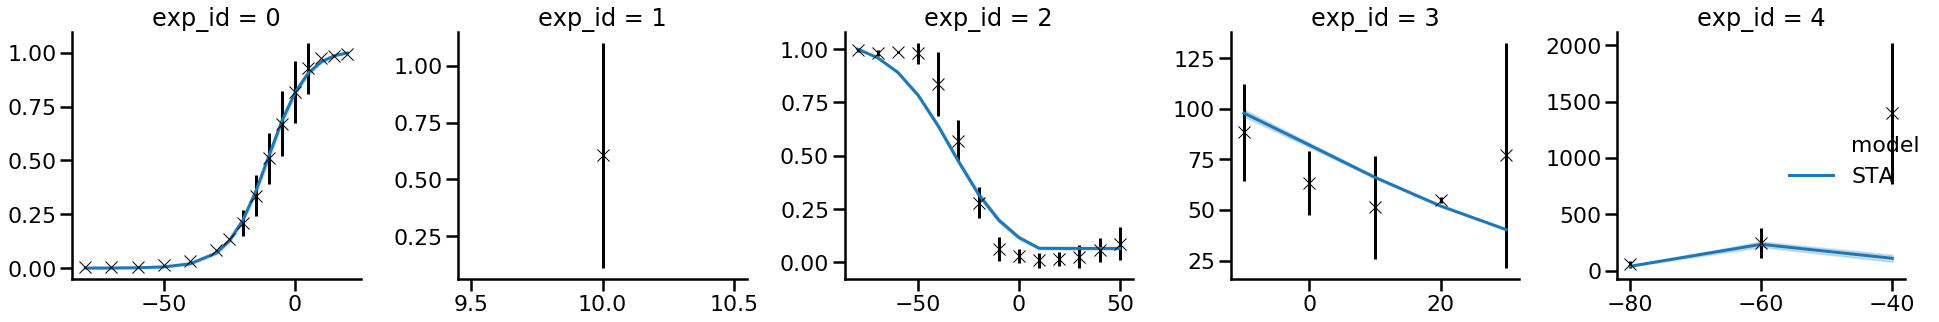

In [24]:
g = plot_sim_results(modelfile,
                     li_act_and_tau,
                     li_inact_1000,
                     li_inact_kin_taus_80,
                     li_recov_taus,
                     df=df, w=w)

In [25]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [26]:
m,_,_ = myokit.load(modelfile)

In [27]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

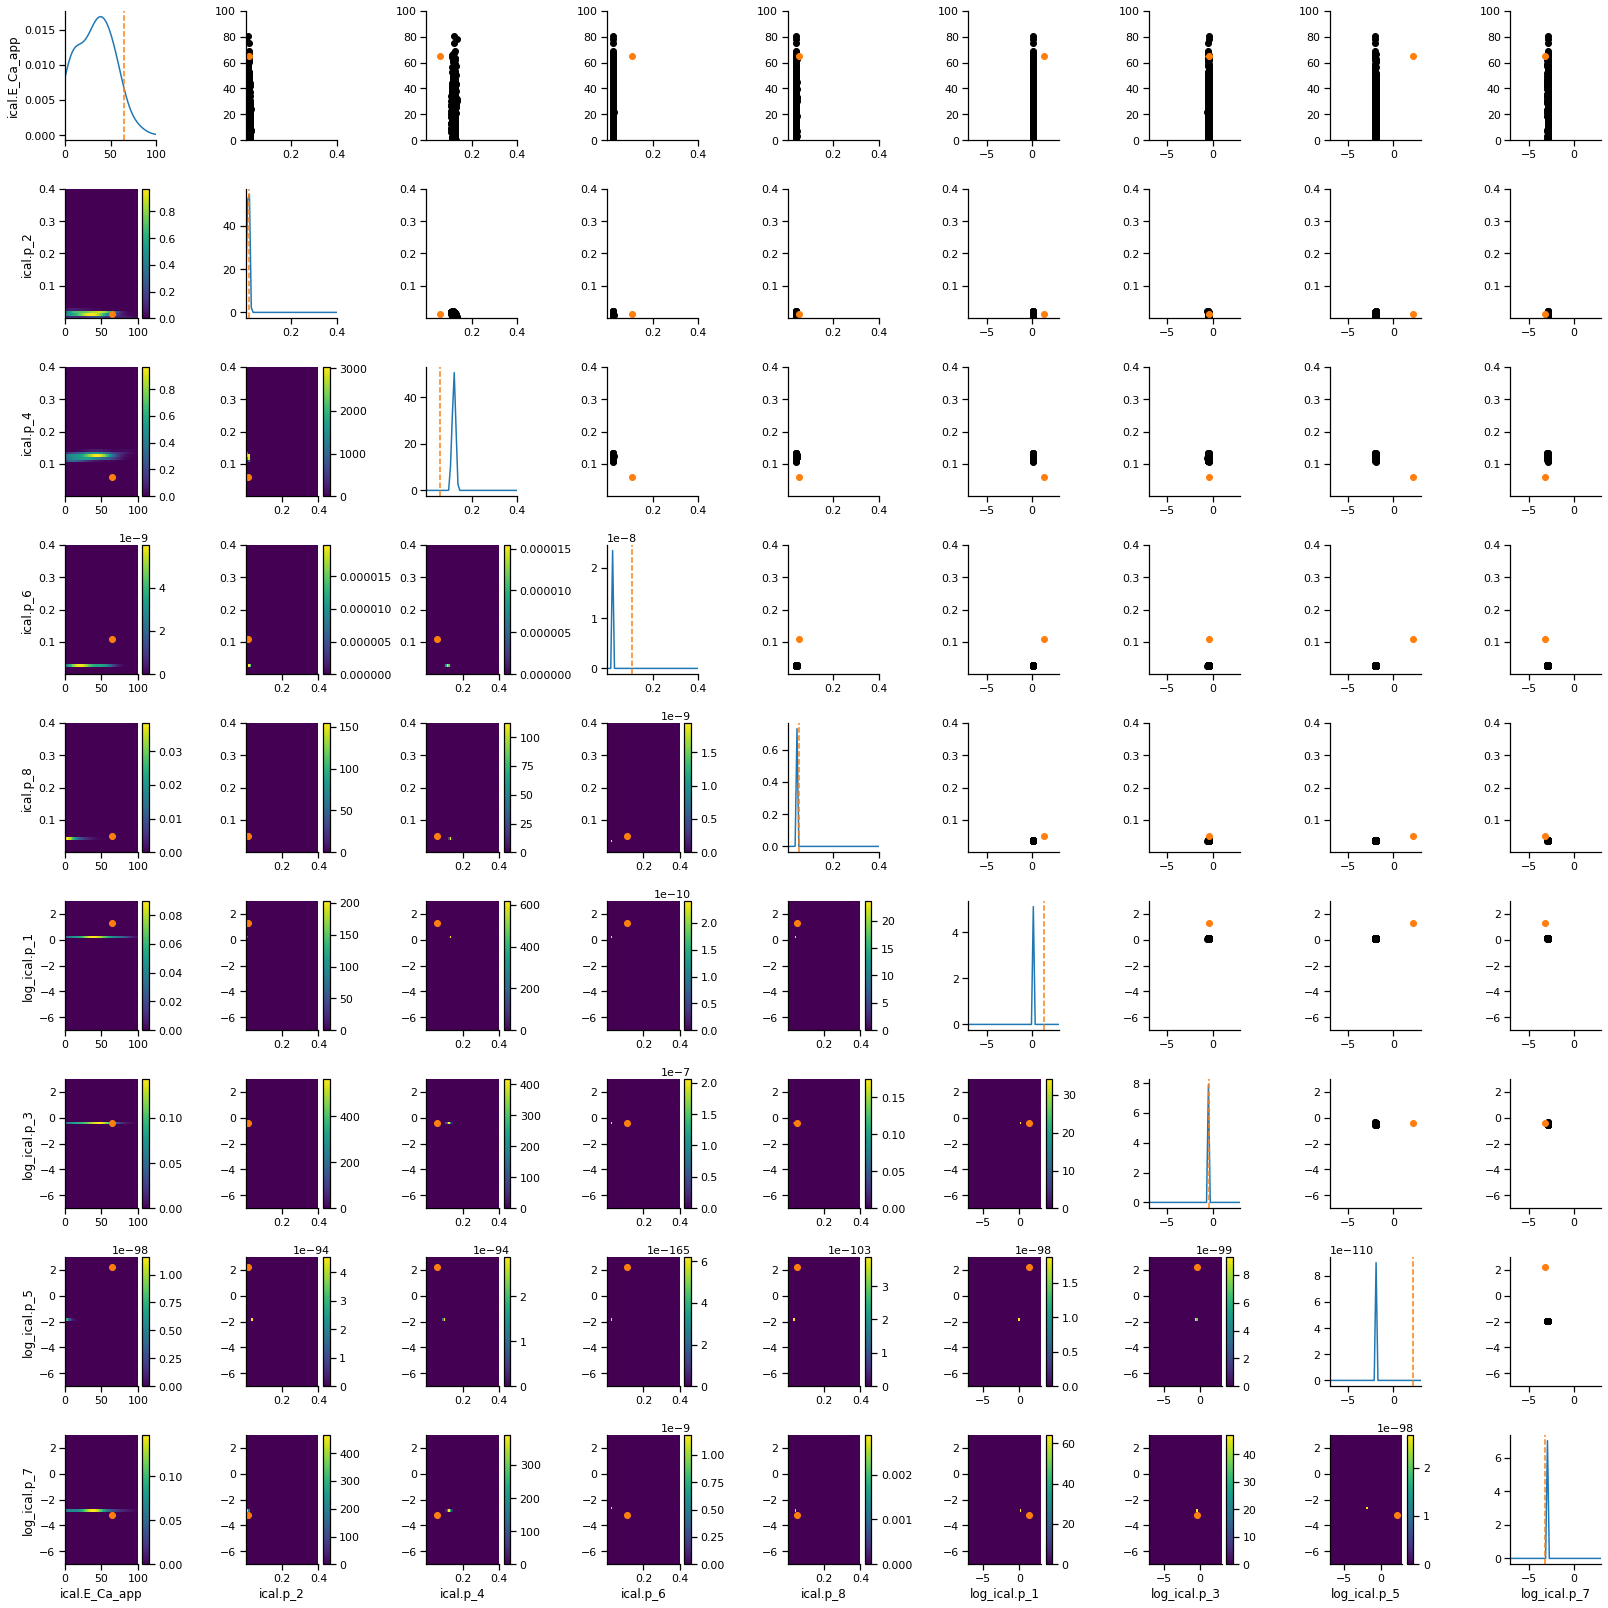

In [28]:
sns.set_context('notebook')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)

In [30]:
sta_pars = df.sample(n=100, weights=w, replace=True)
sta_pars = sta_pars.set_index([pd.Index(range(100))])
sta_pars = sta_pars.to_dict(orient='records')

In [33]:
sta_vars = {'di': 'ical.d_ss',
            'fi': 'ical.f_ss',
            'dt': 'ical.tau_d',
            'ft': 'ical.tau_f'}

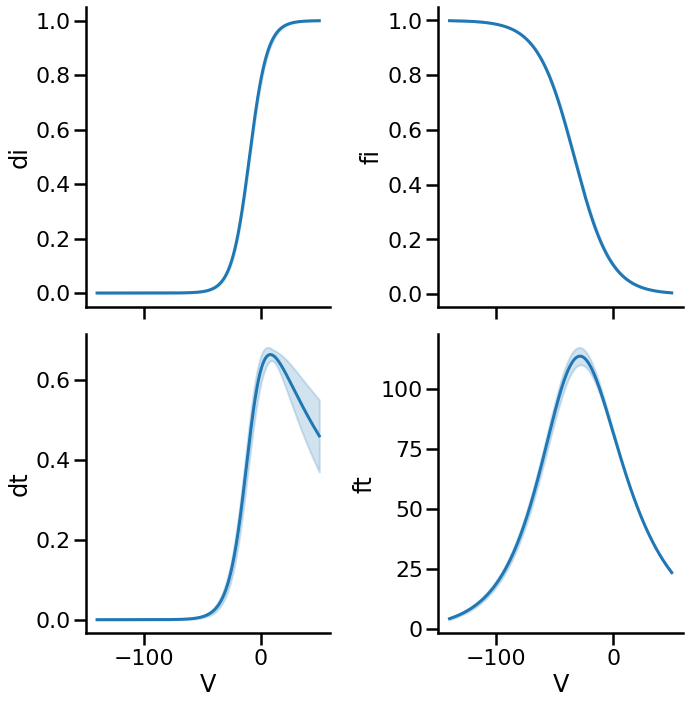

In [34]:
sns.set_context('poster')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, sta_vars, 
                       'models/standardised_ical.mmt', 
                       [sta_pars],
                       figshape=(2,2))